# Task 2

Yifan Luo, u7351505

## 0. Load packages

In [154]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Load RGB images

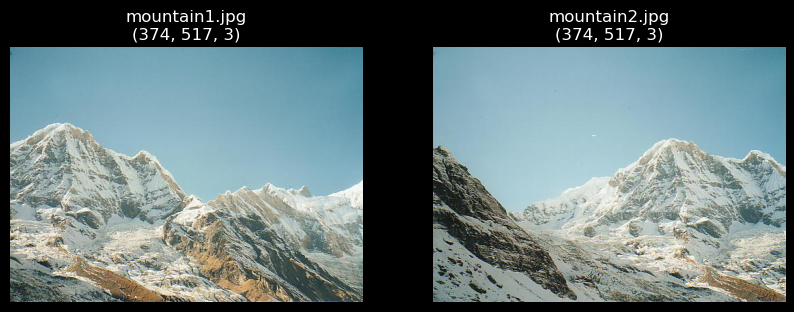

In [155]:
# load RGB images
mountain1 = plt.imread('Task2/images/mountain1.jpg')
mountain2 = plt.imread('Task2/images/mountain2.jpg')

# plot both images
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(mountain1)
ax[0].set_axis_off()
ax[0].set_title(f"mountain1.jpg\n{mountain1.shape}")
ax[1].imshow(mountain2)
ax[1].set_axis_off()
ax[1].set_title(f"mountain2.jpg\n{mountain2.shape}")
plt.show()

## 2. Implement the DLT algorithm `homograpy`

In [156]:
def homography(u1, v1, u2, v2):
    """Implementation of the DLT algorithm for normalised correspondences.

    Args:
        u1 (np.ndarray or list): The normalised row-wise coordinates of the first image.
        v1 (np.ndarray or list): The normalised column-wise coordinates of the first image.
        u2 (np.ndarray or list): The normalised row-wise coordinates of the second image.
        v2 (np.ndarray or list): The normalised column-wise coordinates of the second image.

    Returns:
        H (np.ndarray): The 3*3 homography matrix that wraps (u1, v1) into (u2, v2).
    """
    # input correspondences should have the same length
    if not len(u1) == len(v1) == len(u2) == len(v2):
        raise ValueError("All input arrays should have the same length")
    # homography requires at least 4 correspondences
    if len(u1) < 4:
        raise ValueError("At least 4 corresponding points are required")
    # the number of total correspondences
    n_correspondences = len(u1)
    # initialise the A matrix where each correspondence contributes two independent rows
    A = np.zeros((2 * n_correspondences, 9))
    # construct the A matrix for each correspondence
    for i in range(n_correspondences):
        A[2 * i] = [0, 0, 0, -u1[i], -v1[i], -1, v2[i] * u1[i], v2[i] * v1[i], v2[i]]
        A[2 * i + 1] = [u1[i], v1[i], 1, 0, 0, 0, -u2[i] * u1[i], -u2[i] * v1[i], -u2[i]]
    # use SVD to decompose the A matrix
    U, S, V_t = np.linalg.svd(A)
    # take the rightmost column of V as the length-9 vector h
    h = V_t.T[:, -1]
    # fix the norm of h to 1
    h /= np.linalg.norm(h)
    # reshape (9,) vector h to a (3, 3) matrix H
    H = h.reshape(3, 3)
    # scale the bottom-right element to 1
    H /= H[-1, -1]
    return H

## 3. Implement `compute_normalisation_matrix` and `homography_w_normalisation` functions

In [157]:
def compute_normalisation_matrixs(img1, img2):
    """Generate normalisation matrices for input images.

    Args:
        img1 (np.ndarray): The image to calculate the normalisation matrix T.
        img2 (np.ndarray): The image to calculate the normalisation matrix T'.

    Returns:
        T, T' (tuple(np.ndarray, np.ndarray)): The normalisation matrices for img1 and img2.
    """
    # the height and width for both images
    w1, h1 = img1.shape[1], img1.shape[0]
    w2, h2 = img2.shape[1], img2.shape[0]
    # calculate the normalisation matrix T and T'
    T1 = np.linalg.inv(np.array([[w1 + h1, 0, w1 / 2], 
                                 [0, w1 + h1, h1 / 2], 
                                 [0, 0, 1]]))
    T2 = np.linalg.inv(np.array([[w2 + h2, 0, w2 / 2], 
                                 [0, w2 + h2, h2 / 2], 
                                 [0, 0, 1]]))
    return T1, T2

In [158]:
def homograpy_w_normalisation(img1, u1, v1, img2, u2, v2):
    """Implementation of the DLT algorithm for normalised correspondences.

    Args:
        img1 (np.ndarray): The first image.
        u1 (np.ndarray or list): The unnormalised horizontal coordinates of the first image.
        v1 (np.ndarray or list): The unnormalised vertical coordinates of the first image.
        img2 (np.ndarray): The second image.
        u2 (np.ndarray or list): The unnormalised horizontal coordinates of the second image.
        v2 (np.ndarray or list): The unnormalised vertical coordinates of the second image.
        
    Returns:
        H (np.ndarray): The demormalised homography matrix.
    """
    # input correspondences should have the same length
    if not len(u1) == len(v1) == len(u2) == len(v2):
        raise ValueError("All input arrays should have the same length")
    # homography requires at least 4 correspondences
    if len(u1) < 4:
        raise ValueError("At least 4 corresponding points are required")
    
    # compute the normalisation matrices
    T1, T2 = compute_normalisation_matrixs(img1, img2)
    # construct homography indices
    X1 = np.vstack((u1, v1, np.ones(len(u1))))
    X2 = np.vstack((u2, v2, np.ones(len(u2))))
    # normalise the homography indices with calculated normalisation matrices
    X1_norm = T1 @ X1
    X2_norm = T2 @ X2
    # transform from homography coordinates to Cartesian coordinates
    u1_norm, v1_norm = X1_norm[0] / X1_norm[-1], X1_norm[1] / X1_norm[-1]
    u2_norm, v2_norm = X2_norm[0] / X2_norm[-1], X2_norm[1] / X2_norm[-1]
    # apply DLT algorithm to find the normalised homography
    H_norm = homography(u1_norm, v1_norm, u2_norm, v2_norm)
    # denormalise the homography matrix H_norm
    H = np.linalg.inv(T2) @ H_norm @ T1
    # set H_33 to 1 for normalisation purpose
    H /= H[-1, -1]
    
    return H

## 4. Use SIFT keypoint detector to find correspondences

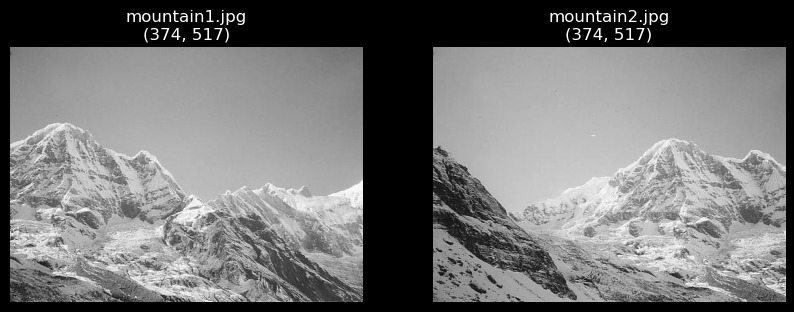

In [159]:
# convert RGB images to grayscale images
mountain1_gray = cv2.cvtColor(mountain1, cv2.COLOR_RGB2GRAY)
mountain2_gray = cv2.cvtColor(mountain2, cv2.COLOR_RGB2GRAY)

# plot both images
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(mountain1_gray, cmap='gray')
ax[0].set_axis_off()
ax[0].set_title(f"mountain1.jpg\n{mountain1_gray.shape}")
ax[1].imshow(mountain2_gray, cmap='gray')
ax[1].set_axis_off()
ax[1].set_title(f"mountain2.jpg\n{mountain2_gray.shape}")
plt.show()

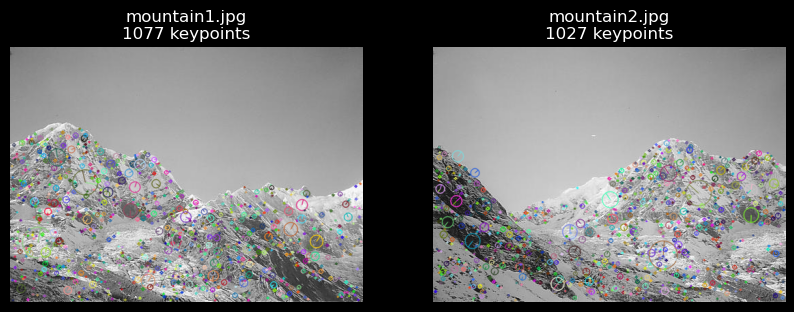

In [160]:
# initialise the SIFT feature detector
sift = cv2.SIFT_create()

mountain1_bgr = cv2.imread('Task2/images/mountain1.jpg')
mountain2_bgr = cv2.imread('Task2/images/mountain2.jpg')

# detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(mountain1_gray, None)
kp2, des2 = sift.detectAndCompute(mountain2_gray, None)

# draw the keypoints
mountain1_sift = cv2.drawKeypoints(mountain1_gray, kp1, mountain1_bgr, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
mountain2_sift = cv2.drawKeypoints(mountain2_gray, kp2, mountain2_bgr, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(mountain1_sift)
ax[0].set_axis_off()
ax[0].set_title(f"mountain1.jpg\n{len(kp1)} keypoints")
ax[1].imshow(mountain2_sift)
ax[1].set_axis_off()
ax[1].set_title(f"mountain2.jpg\n{len(kp2)} keypoints")
plt.show()

In [161]:
# reference: https://docs.opencv.org/4.x/d5/d6f/tutorial_feature_flann_matcher.html

# find matches by using FLANN
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(des1, des2, 2)

# filter matches using the Lowe's ratio test
# the lower the ratio, the fewer the correspondences
ratio = 0.5
all_matches = []
for m, n in knn_matches:
    if m.distance < ratio * n.distance:
        all_matches.append(m)

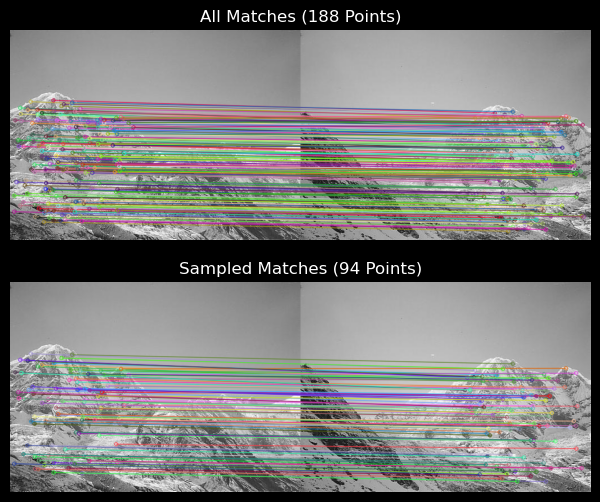

In [162]:
# draw all matches
img_all_matches = np.empty((max(mountain1_gray.shape[0], mountain2_gray.shape[0]), 
                           mountain1_gray.shape[1] + mountain2_gray.shape[1], 3), 
                           dtype=np.uint8)
cv2.drawMatches(mountain1_gray, kp1, mountain2_gray, kp2, all_matches, img_all_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# sample half of the correspondences
np.random.seed(42)
N = int(np.ceil(len(all_matches) / 2))
sample_idx = np.random.choice(len(all_matches), N, replace=False)
sample_matches = np.asarray(all_matches)[sample_idx]

# draw sampled matches
img_matches = np.empty((max(mountain1_gray.shape[0], mountain2_gray.shape[0]), 
                        mountain1_gray.shape[1] + mountain2_gray.shape[1], 3), 
                       dtype=np.uint8)
cv2.drawMatches(mountain1_gray, kp1, mountain2_gray, kp2, sample_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].imshow(img_all_matches)
ax[0].set_title(f"All Matches ({len(all_matches)} Points)")
ax[0].set_axis_off()
ax[1].imshow(img_matches)
ax[1].set_title(f"Sampled Matches ({len(sample_matches)} Points)")
ax[1].set_axis_off()

In [163]:
# convert cv2.DMatch to np.array
samples = np.array([[s.queryIdx, s.trainIdx, s.distance] for s in sample_matches])
# save sampled matches as a .npy file
samples_path = 'Task2/sample_matches.npy'
np.save(samples_path, samples)
print(f"Saved into {samples_path}")
# load samples from .npy file
print(f"Loading from {samples_path}")
samples_load = np.load("Task2/sample_matches.npy")
print(samples_load[:5])

Saved into Task2/sample_matches.npy
Loading from Task2/sample_matches.npy
[[532.         990.         115.73677063]
 [477.         915.         102.95144653]
 [ 94.         554.         149.14086914]
 [ 84.         599.          99.85489655]
 [228.         647.          66.61831665]]


## 5. Implement `homography_w_normalisation_ransac`

In [164]:
def homograpy_w_normalisation_ransac(img1, kp1, img2, kp2, corr, n_matches,
                                     dist_ratio, max_iter=10, seed=42):
    """ Implementation of using RANSAC to select the best performing H
    that has the most amount of inliners
    
    Args:
        img1 (np.ndarray): The input query image.
        kp1 (np.ndarray): The keypoints derived from OpenCV in img1.
        img2 (np.ndarray): The input target image.
        kp1 (np.ndarray): The keypoints derived from OpenCV in img2.
        corr (np.ndarray): The matches from img1 and img2, aligned with kp1 and kp2.
        n_matches (int): The number of matches to sample.
        dist_ratio (float): The ratio of distance for selecting inliners.
        max_iter (int): The max iteration in RANSAC.
        seed (int): The NumPy random seed for sampling in RANSAC.
            
    Returns:
        best_H (np.ndarray): The best performing H that has the most amount of inliners.
    """
    # set the seed for sampling in RANSAC
    np.random.seed(seed)
    # record the maximum number of inliners during RANSAC
    max_inliers = 0
    # record the bast performed H that has the most amount of inliners
    best_H = np.zeros((3, 3))
    for _ in range(max_iter):
        # sample n matches to estimate H
        sample_idx = np.random.choice(len(corr), n_matches, replace=False)
        sample_matches = np.asarray(corr)[sample_idx]
        # construct the coordinates u1, v1, u2, v2 from matches
        u1, v1 = np.array([]), np.array([])
        u2, v2 = np.array([]), np.array([])
        for m in sample_matches:
            v1_, u1_ = kp1[m.queryIdx].pt
            v2_, u2_ = kp2[m.trainIdx].pt
            u1 = np.append(u1, u1_)
            v1 = np.append(v1, v1_)
            u2 = np.append(u2, u2_)
            v2 = np.append(v2, v2_)
        # calculate the homography matrix for unnormalised coordinates
        H = homograpy_w_normalisation(img1, u1, v1, img2, u2, v2)
        # calculate the symmetric transfer error for each correspondence
        X_1 = np.hstack((u1[:, np.newaxis], v1[:, np.newaxis], np.ones((len(u1), 1))))
        X_2 = np.hstack((u2[:, np.newaxis], v2[:, np.newaxis], np.ones((len(u2), 1))))
        # calcute the symmetric transfer error for each match
        sym_trans_err = np.square(X_1.T - np.linalg.inv(H) @ X_2.T).T.sum(axis=1) + \
                        np.square(X_2.T - H @ X_1.T).T.sum(axis=1)
        # calculate the number of inliers that are within dist_ratio * max(dist)
        # record the best H that has the largest number of inliers
        n_inliers = len(sym_trans_err[sym_trans_err < dist_ratio * np.max(sym_trans_err)])
        if n_inliers > max_inliers:
            max_inliers = n_inliers
            best_H = H
        
    return best_H

In [165]:
n_matches = 15
dist_ratio = 0.08
max_iter = 30
best_H = homograpy_w_normalisation_ransac(mountain1_gray, kp1, mountain2_gray, kp2, sample_matches,
                                          n_matches=n_matches, dist_ratio=dist_ratio, max_iter=max_iter)
print(f"Each H is calculated from {n_matches} matches\n\
Inliers are selected under the distance ratio {dist_ratio}\n\
In the total {max_iter} iterations")
print(f"The best H found by RANSAC:\n{best_H}")

Each H is calculated from 15 matches
Inliers are selected under the distance ratio 0.08
In the total 30 iterations
The best H found by RANSAC:
[[ 8.56284452e-01 -2.85902952e-01  5.22110291e+01]
 [ 1.26180424e-01  5.76036098e-01  2.59707366e+02]
 [-1.14877805e-04 -7.47068248e-04  1.00000000e+00]]


## 6. Warp and stitch the images

In [166]:
def calculate_new_size(img, H):
    """ Calculate the transformed image size.
    
    Args:
        img (np.ndarray): The input image to be trasnformed.
        H (np.ndarray): The transformation matrix.
    
    Returns:
        height, width, shift_u, shift_v (tuple(int, int, int, int)): The new size and shift infromation.
        
    """
    corners = np.array([[0, 0, 1],                         # top left
                        [0, img.shape[1], 1],              # top right
                        [img.shape[0], 0, 1],              # bottom left
                        [img.shape[0], img.shape[1], 1]])  # bottom right
    # transformed coordinates by H
    corners_trans = (H @ corners.T).T  # ((3, 3) @ (4, 3).T).T = (4, 3)
    u2 = corners_trans[:, 0] / corners_trans[:, 2]
    v2 = corners_trans[:, 1] / corners_trans[:, 2]
    # find the new height and width of the transfermed image
    height = np.ceil(u2.max() - u2.min()).astype(int)
    width = np.ceil(v2.max() - v2.min()).astype(int)
    # find the shift in both horizontal and vertical directions
    # to calculate the homography coordinates of the tranformed image
    shift_u = np.ceil(u2.min() - 0).astype(int)
    shift_v = np.ceil(v2.min() - 0).astype(int)
    return height, width, shift_u, shift_v


height, width, shift_u, shift_v = calculate_new_size(mountain1, best_H)
print(f"new image height: {height}, width: {width}")
print(f"shift vertically: {shift_u}, horizontally shift_v: {shift_v}")

new image height: 550, width: 800
shift vertically: -155, horizontally shift_v: 260


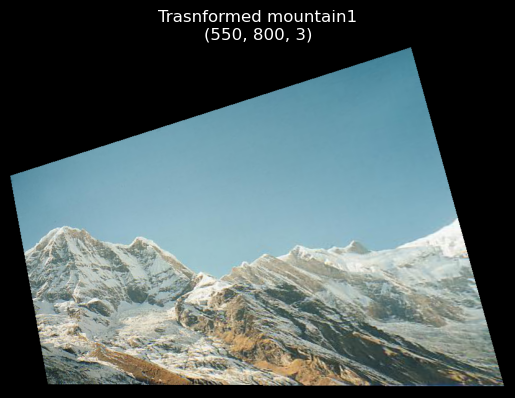

In [167]:
def inverse_warping(img, H):
    """Inverse warping for the input image with the transformation matrix.

    Args:
        img (np.ndarray): The input image to be transformed.
        H (np.ndarray): The transformation matrix

    Returns:
        res (np.ndarray): The transformed image.
    """
    # calculate the size and shift information for later use
    new_height, new_width, shift_u, shift_v = calculate_new_size(mountain1, best_H)
    # initialise the transformed image to return
    res = np.zeros((new_height, new_width, 3 if img.ndim == 3 else 1))
    # check if (u, v) is valid in img
    cond = lambda x, y: (0 <= x < img.shape[0]) and (0 <= y < img.shape[1])
    # iterate over the pixels in res
    for u2 in range(new_height):
        for v2 in range(new_width):
            # the coordinate in target image (X_2 = best_H @ X_1)
            X_2 = np.array([u2 + shift_u, v2 + shift_v, 1])
            # the coordinate in the query image (inv(best_H) @ X2 = X1)
            X_1 = np.linalg.inv(H) @ X_2
            # transform the homography coordinates to Cartesian coordinates
            u1 = X_1[0] / X_1[-1]
            v1 = X_1[1] / X_1[-1]
            if cond(u1, v1):
                if int(u1) == u1 and int(v1) == v1:
                    res[u2, v2] = img[int(u1), int(v1)]
                else:
                    # bilinear interpolation 
                    x1, x2 = int(np.floor(u1)), int(np.ceil(u1))
                    y1, y2 = int(np.floor(v1)), int(np.ceil(v1))
                    if cond(x1, y2) and cond(x2, y2) and cond(x1, y1) and cond(x2, y1):
                        if x1 == x2:
                            res[u2, v2] = img[x1, y2] * (y - y1) / (y2 - y1) + img[x1, x1] * (y2 - y) / (y2 - y1)
                        elif y1 == y2:
                            res[u2, v2] = img[x2, y2] * (x2 - x) / (x2 - x1) + img[x1, y2] * (x - x1) / (x2 - x1)
                        else:
                            R1 = img[x1, y2] * ((x2 - u1) / (x2 - x1)) + img[x2, y2] * ((u1 - x1) / (x2 - x1))
                            R2 = img[x1, y1] * ((x2 - u1) / (x2 - x1)) + img[x2, y1] * ((u1 - x1) / (x2 - x1))
                            res[u2, v2] = R1 * (v1 - y1) / (y2 - y1) + R2 * (y2 - v1) / (y2 - y1)

    return res.astype('uint8')

mountain1_trans = inverse_warping(mountain1, best_H)

# plot the trasnformed result
fig, ax = plt.subplots()
ax.imshow(mountain1_trans)
ax.set_title(f"Trasnformed mountain1\n{mountain1_trans.shape}")
ax.set_axis_off()

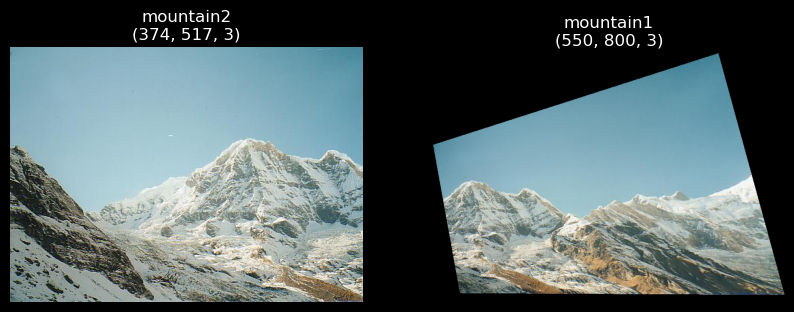

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(mountain2)
ax[0].set_axis_off()
ax[0].set_title(f"mountain2\n{mountain2.shape}")
ax[1].imshow(mountain1_trans)
ax[1].set_axis_off()
ax[1].set_title(f"mountain1\n{mountain1_trans.shape}")
plt.show()

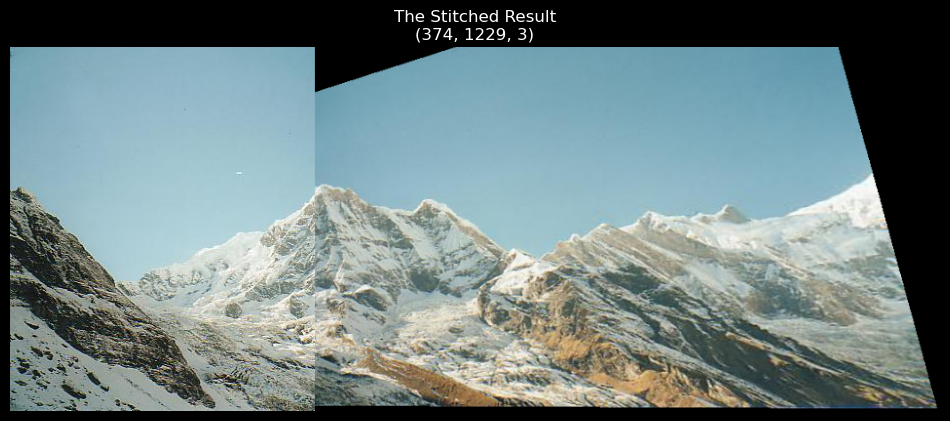

In [169]:
# scale the transformed mountain1
ratio = 0.89
mountain1_resize = cv2.resize(mountain1_trans, (int(mountain1_trans.shape[1] * ratio), 
                                                int(mountain1_trans.shape[0] * ratio)))

# stitch images (left: mountain2, right: mountain1)
stitched_img = np.zeros((374, mountain2.shape[1] + mountain1_resize.shape[1], 3)).astype('uint8')
mountain2_cut = 313
mountain1_cut = 70
stitched_img[:, :mountain2_cut] = mountain2[:, :mountain2_cut]
stitched_img[:, mountain2_cut:(mountain2_cut + (mountain1_resize.shape[1] - mountain1_cut))] = mountain1_resize[mountain1_resize.shape[0] - 374:, mountain1_cut:]

plt.figure(figsize=(12, 8))
plt.title(f"The Stitched Result\n{stitched_img.shape}")
plt.imshow(stitched_img[:, :mountain2_cut + (mountain1_resize.shape[1] - mountain1_cut)])
plt.axis('off')
plt.show()

## 7. Discuss

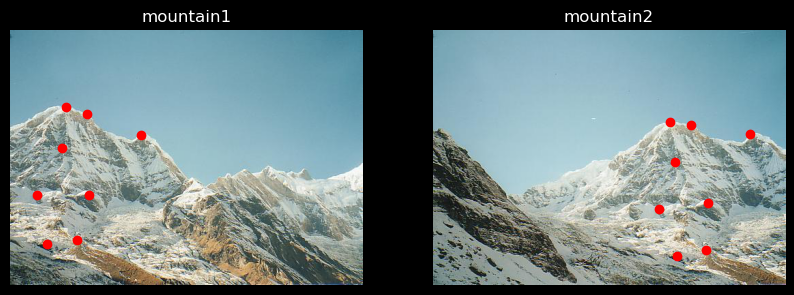

In [170]:
# read manually selected 8 correspondences
points_1 = np.load('Task2/mountain1_point.npy')
points_2 = np.load('Task2/mountain2_point.npy')

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(mountain1)
ax[0].scatter(points_1[:, 0], points_1[:, 1], c='r')
ax[0].set_axis_off()
ax[0].set_title("mountain1")
ax[1].imshow(mountain2)
ax[1].scatter(points_2[:, 0], points_2[:, 1], c='r')
ax[1].set_axis_off()
ax[1].set_title("mountain2")
plt.show()

In [171]:
# calculate the homography matrix with the manually selected correspondeces
H_select = homograpy_w_normalisation(mountain1, points_1[:, 0], points_1[:, 1], 
                                     mountain2, points_2[:, 0], points_2[:, 1])
print(H_select)

[[ 6.37507672e-01  1.00711146e-01  2.59295683e+02]
 [-2.67214379e-01  8.32356450e-01  5.36026067e+01]
 [-6.17521544e-04 -1.86741367e-04  1.00000000e+00]]


In [172]:
height, width, shift_u, shift_v = calculate_new_size(mountain1, H_select)
print(f"new image height: {height}, width: {width}")
print(f"shift vertically: {shift_u}, horizontally shift_v: {shift_v}")

new image height: 559, width: 632
shift vertically: 260, horizontally shift_v: -60


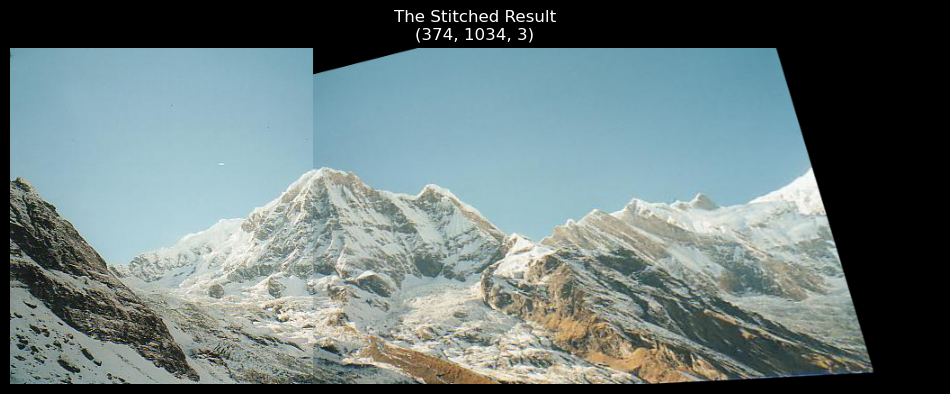

In [173]:
homography_matrix, mask = cv2.findHomography(points_1, points_2, cv2.RANSAC, 5.0)
# warp image2 onto image1's perspective
height, width = mountain2.shape[:2]
stitched_image = cv2.warpPerspective(mountain1, homography_matrix, (width + mountain1.shape[1], height))
# overlay image1 onto the stitched image
shift = 180
stitched_image[:height, :width-shift] = mountain2[:, :-shift]
# display the stitched image
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(stitched_image)
ax.set_title(f"The Stitched Result\n{stitched_image.shape}")
ax.set_axis_off()